In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [2]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's see the structure of the data (here we limit the number of words to be considered):

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


To make the example simpler, we can use part of the whole dataset to define the traing set and validation set. We can split the  dataset with 25000 samples into two parts: 20000 samples for training and 5000 samples for validation.

In [7]:
from tensorflow.data import Dataset

def train_data_creator(config, batch_size):
    # Train on 20000 samples
    (train_feature, train_label), _ = imdb.load_data(num_words=max_features)
    train_feature, train_label = train_feature[0:20000], train_label[0:20000]
    train_feature = sequence.pad_sequences(train_feature, maxlen=maxlen)

    dataset = Dataset.from_tensor_slices((train_feature, train_label))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    return dataset


def val_data_creator(config, batch_size):
    # Validate on 5000 samples
    (val_feature, val_label), _ = imdb.load_data(num_words=max_features)
    val_feature, val_label = val_feature[20000:25000], val_label[20000:25000]
    val_feature = sequence.pad_sequences(val_feature, maxlen=maxlen)

    dataset = Dataset.from_tensor_slices((val_feature, val_label))
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

Let's define a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [8]:
from tensorflow.keras.layers import Dense

def model_creator(config):
    model = Sequential()
    model.add(Embedding(max_features, 32))
    model.add(SimpleRNN(32))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

We are now ready to train our network using Orca Estimator. Firstly, we need to initialize the Orca context by specifying local or distributed mode.

In [9]:
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).
cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cluster_mode="local", cores=4)  # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2)  # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2)  # run on Hadoop YARN cluster

Then we can fit the model using Orca Estimator. The number of steps for training or validation can be found as dividing the dataset size by batch size. To record the training and validation loss and accuracy of each epoch, we can use a loop to train the model, with `epochs = 1` for each iteration. The `est.fit` function returns the latest loss and accuracy of that training period.

In [10]:
from zoo.orca.learn.tf2 import Estimator

max_epoch = 10
batch_size = 128

est = Estimator.from_keras(model_creator=model_creator)
history = []
for i in range(max_epoch):
    status = est.fit(data=train_data_creator,
                     epochs=1,
                     batch_size=batch_size,
                     steps_per_epoch=20000 // batch_size,
                     validation_data=val_data_creator,
                     validation_steps=5000 // batch_size)
    history.append(status)  # record training history of each epoch

est.shutdown()  # end the training session

...
156/156 [==============================] - 16s 101ms/step - loss: 0.0427 - accuracy: 0.9856 - val_loss: 0.6942 - val_accuracy: 0.7841


Let's display the training and validation loss and accuracy:

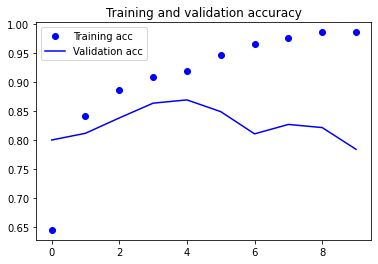

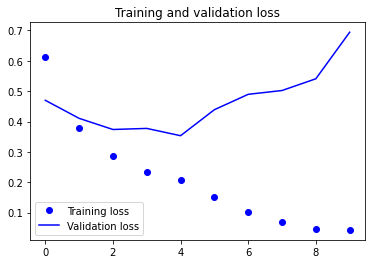

In [11]:
import matplotlib.pyplot as plt

acc = [history[i]["train_accuracy"] for i in range(max_epoch)]
val_acc = [history[i]["train_val_accuracy"] for i in range(max_epoch)]
loss = [history[i]["train_loss"] for i in range(max_epoch)]
val_loss = [history[i]["train_val_loss"] for i in range(max_epoch)]

epochs = range(max_epoch)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [12]:
from tensorflow.keras.layers import LSTM

def model_creator_LSTM(config):
    model = Sequential()
    model.add(Embedding(max_features, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


est = Estimator.from_keras(model_creator=model_creator_LSTM)
history = []
for i in range(max_epoch):
    status = est.fit(data=train_data_creator,
                     epochs=1,
                     batch_size=batch_size,
                     steps_per_epoch=20000 // batch_size,
                     validation_data=val_data_creator,
                     validation_steps=5000 // batch_size)
    history.append(status)  # record training history of each epoch

est.shutdown()  # end the training session

...
156/156 [==============================] - 32s 204ms/step - loss: 0.1131 - accuracy: 0.9607 - val_loss: 0.3495 - val_accuracy: 0.8812


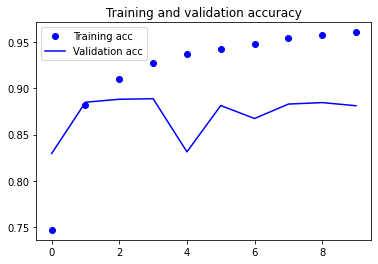

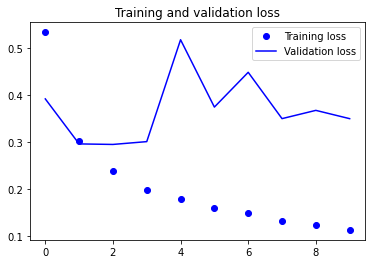

In [13]:
acc = [history[i]["train_accuracy"] for i in range(max_epoch)]
val_acc = [history[i]["train_val_accuracy"] for i in range(max_epoch)]
loss = [history[i]["train_loss"] for i in range(max_epoch)]
val_loss = [history[i]["train_val_loss"] for i in range(max_epoch)]

epochs = range(max_epoch)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Don't forget to call `stop_orca_context()` when the program finishes.

In [14]:
stop_orca_context()

Stopping orca context
